# **NLP with Coronavirus Tweets using Long Short-Term Memory Networks**
#### Kate Pendavinji
#### **Repository Link:** [Project Repo](https://github.com/kape6379/corona.git)

### **Gather Data:**

My data was gathered from [kaggle](https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification?select=Corona_NLP_train.csv). It pertains to twitter data regarding tweets related to the Coronavirus Pandemic.

The data is split up into testing and training data. They will be read from a CSV which I will go on to explore further in my data exploration section.


### **Identify a Deep Learning Problem:**
The deep learning problem I seek to answer is to automate the classification of pandemic related tweets based on the sentiment of the tweet (positive, negative, neutral, etc.). In order to do this I will be using _natural language processing_ on the tweets similarly to the week 4 project and seeing if long short-term memory networks can give us accurate predictions of the sentiments of our data. I will then attempt to see how using an SGD optimizer affects the accuracy of our training and test accuracies and losses.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
import scipy as sp
import scipy.stats as stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import string
from collections import Counter
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder



import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from gensim.models import Word2Vec
import re
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# Exploratory Data Analysis

First we will take a quick look into our data to see what our data looks like.

As we can see our training consists of 41,157 rows and 6 columns with the columns labeled as follows:
* UserName
* ScreenName
* Location
* TweetAt (date)
* OriginalTweet

Our test data has the exact same columns, but is smaller with only 3798 rows. Based on the first few lines of each of these data frames we can see that there are a lot of special characters and more making our data messy. We will handle that through data cleaning that utilizes natural lnaguage proccessing.

First, let's see some more correlations about our data as it is to see where to start.

In [50]:
# read in files from drive
train_file = '/content/drive/My Drive/corona/Corona_NLP_train.csv'
test_file = '/content/drive/My Drive/corona/Corona_NLP_test.csv'

# assign test and train  data frames with suggested encoding (google colab error resolution suggestion)
train = pd.read_csv(train_file, encoding='latin-1')
test = pd.read_csv(test_file, encoding='latin-1')
# show insights
print("Training Data Head \n\n", train.head(), "\n")
print("Testing Data Head \n\n", test.head(),"\n")
print("\n", train.shape)
print("\n", test.shape)

Training Data Head 

    UserName  ScreenName   Location     TweetAt  \
0      3799       48751     London  16-03-2020   
1      3800       48752         UK  16-03-2020   
2      3801       48753  Vagabonds  16-03-2020   
3      3802       48754        NaN  16-03-2020   
4      3803       48755        NaN  16-03-2020   

                                       OriginalTweet           Sentiment  
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral  
1  advice Talk to your neighbours family to excha...            Positive  
2  Coronavirus Australia: Woolworths to give elde...            Positive  
3  My food stock is not the only one which is emp...            Positive  
4  Me, ready to go at supermarket during the #COV...  Extremely Negative   

Testing Data Head 

    UserName  ScreenName             Location     TweetAt  \
0         1       44953                  NYC  02-03-2020   
1         2       44954          Seattle, WA  02-03-2020   
2         3       44955 

# Exploratory Data Analysis

Below we create a histogram and a box plot to see the makeup of our data.

The histogram features word count frequency within our tweets. It seems we have a few outliers, so we will try to normalize this in future steps.

Our box plot shows how tweet lengths distribute sentiments within our data. They already look pretty normally distributed, so we will focus on data processing word frequencies.

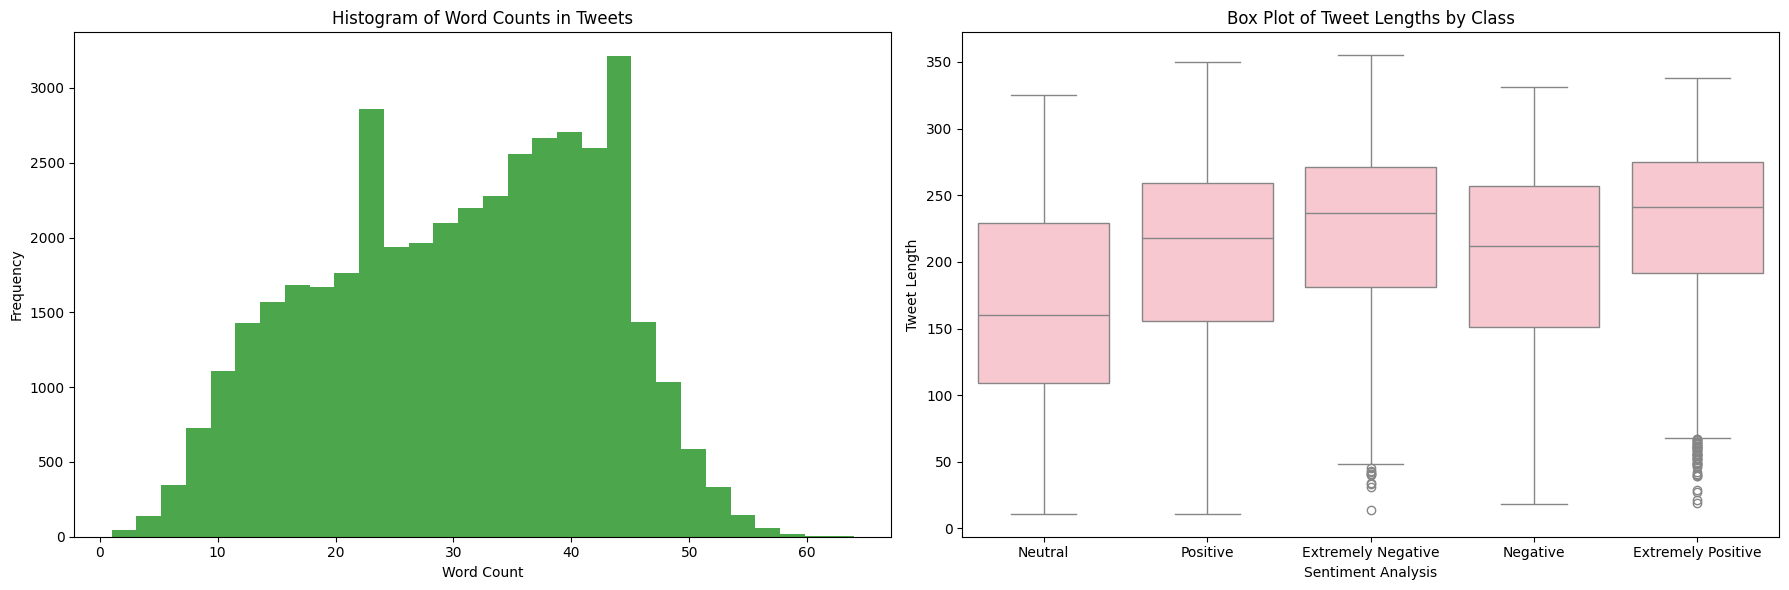

In [52]:
train['tweet_length'] = train['OriginalTweet'].apply(len)
train['word_count'] = train['OriginalTweet'].apply(lambda x: len(x.split()))

plt.figure(figsize=(18, 6))

# histogram plot
plt.subplot(1, 2, 1)
plt.hist(train['word_count'], bins=30, color='green', alpha=0.7)
plt.title('Histogram of Word Counts in Tweets')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
# box plot
plt.subplot(1, 2, 2)
sns.boxplot(x='Sentiment', y='tweet_length', data=train, color='pink')
plt.title('Box Plot of Tweet Lengths by Class')
plt.xlabel('Sentiment Analysis')
plt.ylabel('Tweet Length')

plt.tight_layout()

plt.show()

# Exploratory Data Analysis

Below we perform our data preprocessing and natural language processing in the following ways:
* normalizing the text
  - normalization of the text will make our data cleaner and therefore more evenly distributed due to increased relevancy of content
* making text lowercase
  - making the text lowercase will make all of our text look the same making it easier to run training models on
* removing punctuation
  - removing punctuation will make our data entirely text based which is helpful to normalize data that has punctuation that is not meaningful such as typos
* tokenizing
 - tokenizing our text is our first instance of natural language processing that allows for the simplification of the content of our data to be further processed
* remove stop words & lemmatize
  -this removes common words such as "the" and "and" and also reduces diferent tenses and prefixes of words in order to simplify our data
* remove URLs
  - based on the first fiew lines of our data frame it was evident that there were a lot of links and special characters in our text which had been removed in order to only keep meaningful English words
* remove mentions
  - removing mentions removes the @ symbol and names which aren't relevant to the sentiment of the makeup of words in a tweet


  It is evident from the comparison of original text to cleaned text that we have processed the data to contain relevant information. Graphics on this will be available below.
    

In [31]:
stop = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

# normalizing the text
def preprocessing(text):
    # making text lowercase
    text = text.lower()
    # removing punctuation
    text = ''.join([char for char in text if char not in string.punctuation])
    # tokenizing
    text = word_tokenize(text)
    # remove stop words & lemmatize
    filter = [lemmatizer.lemmatize(word) for word in text if word not in stop]
    text = ' '.join(filter)
    # remove URLs
    text = re.sub(r'http\S+', '', text)
    # remove mentions
    text = re.sub(r'@\w+', '', text)
    return text
# Apply preprocessing
train['clean_text'] = train['OriginalTweet'].apply(preprocessing)
test['clean_text'] = test['OriginalTweet'].apply(preprocessing)

print(train[['OriginalTweet', 'clean_text']].head())

                                       OriginalTweet  \
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...   
1  advice Talk to your neighbours family to excha...   
2  Coronavirus Australia: Woolworths to give elde...   
3  My food stock is not the only one which is emp...   
4  Me, ready to go at supermarket during the #COV...   

                                          clean_text  
0                     menyrbie philgahan chrisitv     
1  advice talk neighbour family exchange phone nu...  
2  coronavirus australia woolworth give elderly d...  
3  food stock one empty please dont panic enough ...  
4  ready go supermarket covid19 outbreak im paran...  


# Exploratory Data Analysis

Below you'll see four histograms comparing our orignal text to our cleaned text.

* Length

The length of tweets in comparison to the frequency of our tweets is a lot more normally distributed now. We've eliminated outliers through preprocessing and we have a much more even data frame now.

* Top Words

One of the most important things we want to look at is if we've narrowed our view on relevant frequent words. Initially our most frequent words were "#, the, to, ., :, ', and, https,?, of" and now they are "coronavirus, covid19, price, store, supermarket, food, grocery, people, consumer, and amp". The relevance of our frequent data is substantially better and we are ready to try to run our models on it!

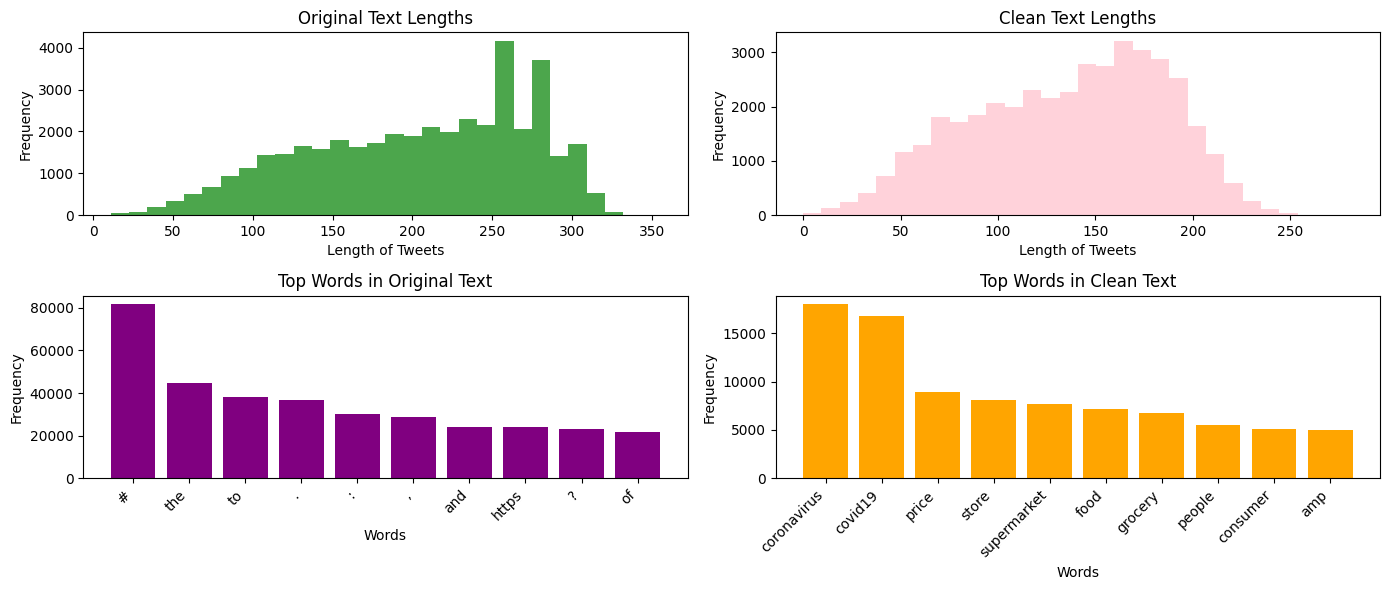

In [37]:
train['original_length'] = train['OriginalTweet'].apply(len)
train['clean_length'] = train['clean_text'].apply(len)

original_words = word_tokenize(' '.join(train['OriginalTweet']).lower())
original_counter = Counter(original_words)
most_common_original = original_counter.most_common(10)
original_words, original_counts = zip(*most_common_original)

clean_words = word_tokenize(' '.join(train['clean_text']).lower())
clean_counter = Counter(clean_words)
most_common_clean = clean_counter.most_common(10)
clean_words, clean_counts = zip(*most_common_clean)

plt.figure(figsize=(14, 6))
plt.subplot(2, 2, 1)

plt.hist(train['original_length'], bins=30, color='green', alpha=0.7)
plt.title('Original Text Lengths')
plt.xlabel('Length of Tweets')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
plt.hist(train['clean_length'], bins=30, color='pink', alpha=0.7)
plt.title('Clean Text Lengths')
plt.xlabel('Length of Tweets')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
plt.bar(original_words, original_counts, color='purple')
plt.title('Top Words in Original Text')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')

plt.subplot(2, 2, 4)
plt.bar(clean_words, clean_counts, color='orange')
plt.title('Top Words in Clean Text')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Perform Analysis Using Deep Learning Model: LSTM

Below we begin by making a basic long short-term memory neural network model (LSTM). LSTM's are a type of RNN model trained to process a sequential data input and convert into an output.


I decided this was appropriate for our situation as our data largely deals with sequential data. Coronavirus is a sequential situation and people's sentiment (retrieved from tweets) are something that changes sequentially.

We begin by vectorizing our data utilizing a natural language processing method calle TF-IDF. This helps us input the importance and relevance of our data into a LSTM model. We then look at our model summary and epoch history. Below our models are graphical representations of our model accuracy and our model loss for our train and test data.

As you can see from the model history, our model starts out with a very low accuracy and a large amount of loss. Luckily as we traverse through epochs our accuracy manages to get up to 60%, but our loss continues to remain pretty high. We will move forward to try different methods to improve our results below.

In [39]:
# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = vectorizer.fit_transform(train['clean_text']).toarray()
X_test_tfidf = vectorizer.transform(test['clean_text']).toarray()
# reshape vectorizer for model
X_train_tfidf = X_train_tfidf.reshape(-1, 1, 1000)
X_test_tfidf = X_test_tfidf.reshape(-1, 1, 1000)

# encode sentiment data into categorical data in order to better define targets
encoder = LabelEncoder()
y_train = to_categorical(encoder.fit_transform(train['Sentiment']))
y_test = to_categorical(encoder.transform(test['Sentiment']))

num_classes = train['Sentiment'].nunique()
# create model
model = Sequential([
    LSTM(50,
         activation = "tanh",
         recurrent_activation = "sigmoid",
         input_shape=(1, 1000)),
    Dropout(0.2),
    Dense(num_classes, activation='softmax') # softmax due to multiple categories
])

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 50)                210200    
                                                                 
 dropout_10 (Dropout)        (None, 50)                0         
                                                                 
 dense_10 (Dense)            (None, 5)                 255       
                                                                 
Total params: 210455 (822.09 KB)
Trainable params: 210455 (822.09 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [40]:
history = model.fit(X_train_tfidf, y_train, epochs=10, validation_split=0.2, batch_size=32)

Epoch 1/10
1029/1029 [==============================] - 15s 12ms/step - loss: 1.3459 - accuracy: 0.4260 - val_loss: 1.1347 - val_accuracy: 0.5531
Epoch 2/10
1029/1029 [==============================] - 9s 9ms/step - loss: 1.0994 - accuracy: 0.5632 - val_loss: 1.0856 - val_accuracy: 0.5747
Epoch 3/10
1029/1029 [==============================] - 9s 8ms/step - loss: 1.0626 - accuracy: 0.5799 - val_loss: 1.0856 - val_accuracy: 0.5730
Epoch 4/10
1029/1029 [==============================] - 10s 10ms/step - loss: 1.0493 - accuracy: 0.5885 - val_loss: 1.0854 - val_accuracy: 0.5745
Epoch 5/10
1029/1029 [==============================] - 9s 9ms/step - loss: 1.0402 - accuracy: 0.5930 - val_loss: 1.0851 - val_accuracy: 0.5719
Epoch 6/10
1029/1029 [==============================] - 9s 8ms/step - loss: 1.0324 - accuracy: 0.5927 - val_loss: 1.0856 - val_accuracy: 0.5734
Epoch 7/10
1029/1029 [==============================] - 9s 9ms/step - loss: 1.0265 - accuracy: 0.5978 - val_loss: 1.0854 - val_accur

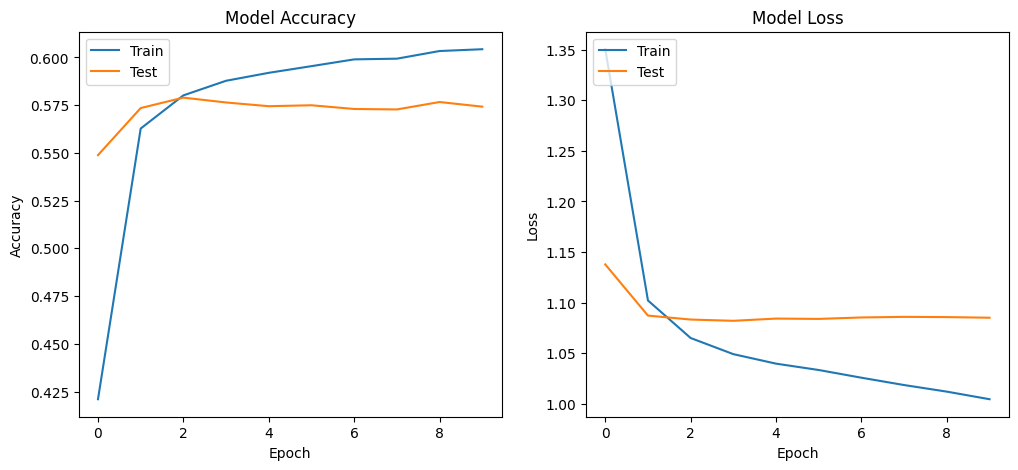

In [27]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

# Perform Analysis Using Deep Learning Model: SGD Optimization

We will now consider another model. Out of curiosity of improving the model I wanted to see if optimizing with stochastic gradient descent. I figured that since we have a decently large dataframe that it might be helpful to try to optimize it using methods from previous units. I also thought it would be helpful to test and see how learning rates impacted our model.

As you can see from our accuracy and loss graphs as well as histories, it did not perform well. We will still proceed to compare how hyperparameter optimization affects our outcoms with both regular LSTM and LSTM with SGD optimization in the discussion section next.

In [30]:
# same model
modelSGD = Sequential([
    LSTM(50,
         activation = "tanh",
         recurrent_activation = "sigmoid",
         input_shape=(1, 1000)),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])
# implement SGD optimizer
optimizer = SGD(learning_rate=0.001, momentum=1)

modelSGD.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
modelSGD.summary()

# apply to training
historySGD = modelSGD.fit(X_train_tfidf, y_train, epochs=10, validation_split=0.2, batch_size=32)


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 50)                210200    
                                                                 
 dropout_9 (Dropout)         (None, 50)                0         
                                                                 
 dense_9 (Dense)             (None, 5)                 255       
                                                                 
Total params: 210455 (822.09 KB)
Trainable params: 210455 (822.09 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
1029/1029 [==============================] - 10s 8ms/step - loss: 1.6064 - accuracy: 0.2532 - val_loss: 1.6290 - val_accuracy: 0.2681
Epoch 2/10
1029/1029 [==============================] - 8s 8ms/step - loss: 1.4931 - accuracy: 0.3161 - val_loss: 1.3576 - val_accura

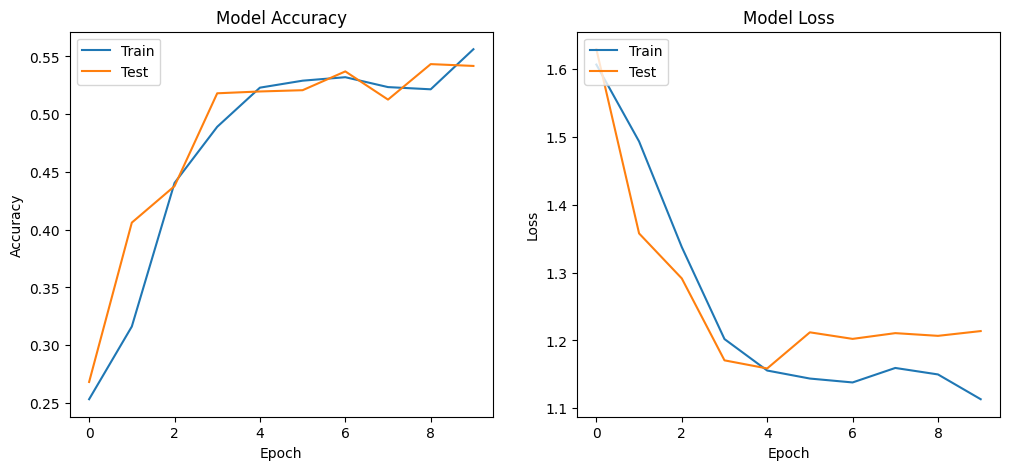

In [42]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(historySGD.history['accuracy'])
plt.plot(historySGD.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(historySGD.history['loss'])
plt.plot(historySGD.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

# Present Discussion: Hyperparemeter Optimization of Models

In this section we will experiment with hyperparameter optimization.

We will start by applying hyperparameter optimization on our regular LSTM models. I created 3 other models all with different acitvations, recurrent activations, dropouts, and filters we can see that one of the models was able to increase our accuracy by almost 5% and also reduce loss. This model is Model 3.

Model 3 has the best outcome due to a number of factors:
* activation combination
  - an activation of "tanh" and recurrent activation of "relu" was a good combination for our data.
* dropout layer
  - the dropout layer being set at 0.2 lowered overfitting in our training data limiting narrowing our data and encouraging accurate generalizations.
* number of units
  - I chose 50 units for this model which ended up being a good amount.

  Output layer and optimzer had to remain constant between these due to having more than 2 classes for grouping. Below I will explore hyperparameter optmization with our SGD model and discuss how that differed from this hyperparemter optimization results.

In [43]:
model2 = Sequential([
    LSTM(50,
         activation = "relu",
         recurrent_activation = "tanh",
         input_shape=(1, 1000)),
    Dropout(0.5),
        Dense(num_classes, activation='softmax')
])

model2.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
model2.summary()
history2 = model2.fit(X_train_tfidf, y_train, epochs=10, validation_split=0.2, batch_size=32)

#####################################################################################################################################################

model3 = Sequential([
    LSTM(50,
         activation = "tanh",
         recurrent_activation = "relu",
         input_shape=(1, 1000)),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

model3.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
model3.summary()
history3 = model3.fit(X_train_tfidf, y_train, epochs=10, validation_split=0.2, batch_size=32)

#####################################################################################################################################################

model4 = Sequential([
    LSTM(30,
         activation = "tanh",
         recurrent_activation = "relu",
         input_shape=(1, 1000)),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

model4.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
model4.summary()
history4 = model4.fit(X_train_tfidf, y_train, epochs=10, validation_split=0.2, batch_size=32)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 50)                210200    
                                                                 
 dropout_11 (Dropout)        (None, 50)                0         
                                                                 
 dense_11 (Dense)            (None, 5)                 255       
                                                                 
Total params: 210455 (822.09 KB)
Trainable params: 210455 (822.09 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
1029/1029 [==============================] - 9s 8ms/step - loss: 1.4054 - accuracy: 0.3804 - val_loss: 1.1750 - val_accuracy: 0.5317
Epoch 2/10
1029/1029 [==============================] - 8s 8ms/step - loss: 1.1676 - accuracy: 0.5208 - val_loss: 1.1009 - val_accura

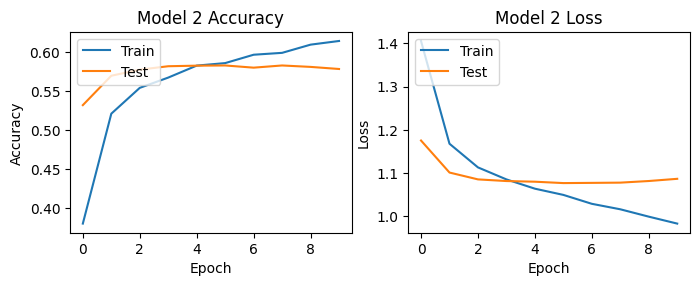

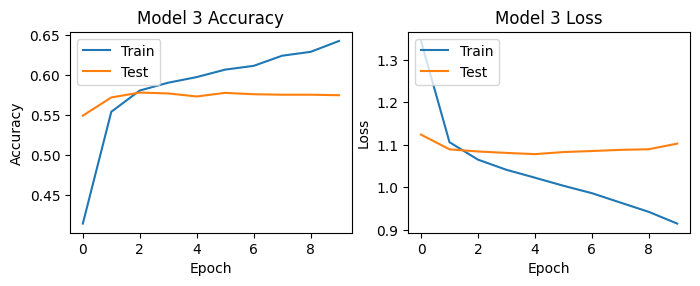

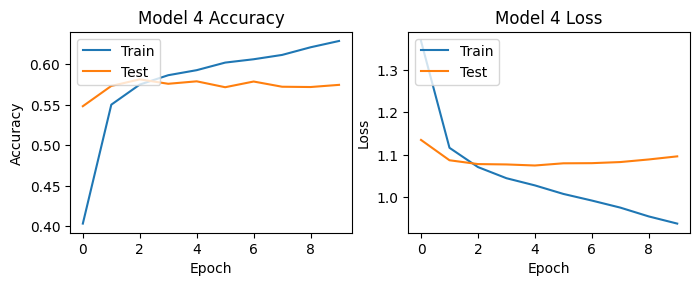

In [44]:
plt.figure(figsize=(8, 12))
plt.subplot(4, 2, 1)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model 2 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(4, 2, 2)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model 2 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.figure(figsize=(8, 12))
plt.subplot(4, 2, 3)
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model 3 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(4, 2, 4)
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model 3 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.figure(figsize=(8, 12))
plt.subplot(4, 2, 5)
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('Model 4 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(4, 2, 6)
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Model 4 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')


plt.show()

# Present Discussion: Hyperparemeter Optimization of Models

Although our SGD model did not perform well I decided to still try to run hyperparemter optimization on it. LSTM parameters remained constant, and rather I wanted to observe how changing learning rates on the optimizer affected our results.

Unfortunately our outcomes were not very exciting. All of these models performed marginally worse than the first one which used a learning rate of 0.001. This makes a lot of sense if you recall our unit 2 SGD's which did not perform well with extremely low and extremely high learning rates. It was high enough to keep our learning process quick while also being more stable than a high learning rate. It overperformed all other SGD optimized models by 20%+. It still underperformed the highest perfoerming regular LSTM by 10%.

In [45]:
modelSGD2 = Sequential([
    LSTM(50,
         activation = "tanh",
         recurrent_activation = "relu",
         input_shape=(1, 1000)),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

optimizer = SGD(learning_rate=0.0005, momentum=1)

modelSGD2.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
modelSGD2.summary()


historySGD2 = modelSGD2.fit(X_train_tfidf, y_train, epochs=10, validation_split=0.2, batch_size=32)


#####################################################################################################################################################

modelSGD3 = Sequential([
    LSTM(50,
         activation = "tanh",
         recurrent_activation = "relu",
         input_shape=(1, 1000)),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])


optimizer = SGD(learning_rate=0.001, momentum=1)

modelSGD3.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
modelSGD3.summary()


historySGD3 = modelSGD3.fit(X_train_tfidf, y_train, epochs=10, validation_split=0.2, batch_size=32)

#####################################################################################################################################################

modelSGD4 = Sequential([
    LSTM(50,
         activation = "tanh",
         recurrent_activation = "relu",
         input_shape=(1, 1000)),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])


optimizer = SGD(learning_rate=0.1, momentum=1)

modelSGD4.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
modelSGD4.summary()


historySGD4 = modelSGD4.fit(X_train_tfidf, y_train, epochs=10, validation_split=0.2, batch_size=32)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 50)                210200    
                                                                 
 dropout_14 (Dropout)        (None, 50)                0         
                                                                 
 dense_14 (Dense)            (None, 5)                 255       
                                                                 
Total params: 210455 (822.09 KB)
Trainable params: 210455 (822.09 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
1029/1029 [==============================] - 10s 8ms/step - loss: 1.5949 - accuracy: 0.2651 - val_loss: 1.5966 - val_accuracy: 0.2230
Epoch 2/10
1029/1029 [==============================] - 11s 11ms/step - loss: 1.6037 - accuracy: 0.2365 - val_loss: 1.5992 - val_acc

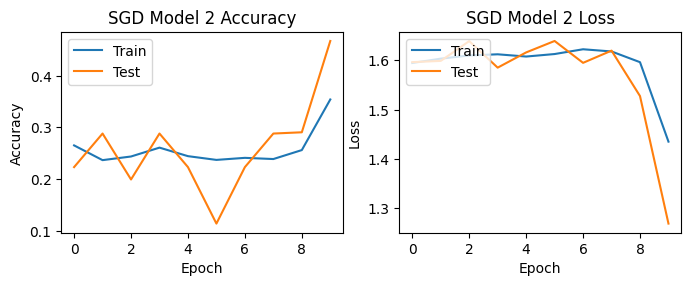

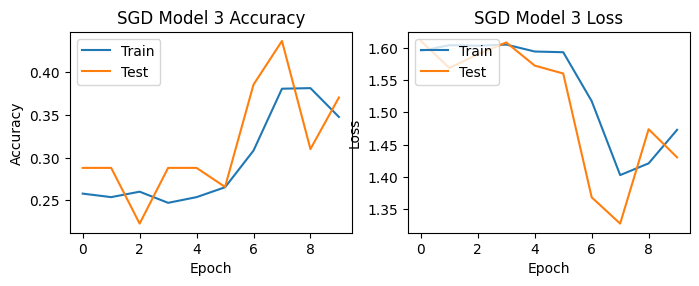

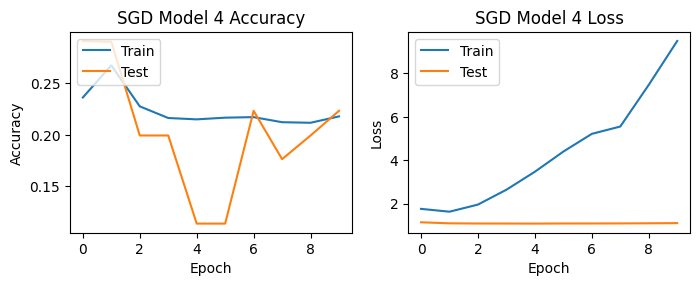

In [47]:
plt.figure(figsize=(8, 12))
plt.subplot(4, 2, 1)
plt.plot(historySGD2.history['accuracy'])
plt.plot(historySGD2.history['val_accuracy'])
plt.title('SGD Model 2 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(4, 2, 2)
plt.plot(historySGD2.history['loss'])
plt.plot(historySGD2.history['val_loss'])
plt.title('SGD Model 2 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.figure(figsize=(8, 12))
plt.subplot(4, 2, 3)
plt.plot(historySGD3.history['accuracy'])
plt.plot(historySGD3.history['val_accuracy'])
plt.title('SGD Model 3 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(4, 2, 4)
plt.plot(historySGD3.history['loss'])
plt.plot(historySGD3.history['val_loss'])
plt.title('SGD Model 3 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.figure(figsize=(8, 12))
plt.subplot(4, 2, 5)
plt.plot(historySGD4.history['accuracy'])
plt.plot(historySGD4.history['val_accuracy'])
plt.title('SGD Model 4 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(4, 2, 6)
plt.plot(historySGD4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('SGD Model 4 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')


plt.show()

# Conclusions

Overall, our LSTM model optimized our Coronavirus tweet data much better than an LSTM optimized by SGD. We were able to reduce the noise in our data just through natural language processing and data analysis. This assisted accurately seeing how accurately we could target our data based off of text alone.

We thoroughly observed the affects of hyperparemter optmization and were able to improve our results by 5%. We successfuly managed our once complex data and gave insight into a very complex and emotionally stimulated subject such as the Coronavirus.